<a href="https://colab.research.google.com/github/AndresFWilT/MINE_4210_ADL_202520/blob/taller-2/labs/Laboratorio_5/MINE__4210_ADL_202520_L5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo ADL](https://github.com/nicolastibata/MINE_4210_ADL_202520/blob/main/docs/images/logo.png?raw=true)


# **Laboratorio 5: Redes CNN para detección de objetos**
**Tutor: Nicolás Tibatá**

## **Tabla de Contenido**

[Contexto y objetivos](#scrollTo=5KnQpgpopi8a)<br>
[1. Introducción de los datos](#scrollTo=VjA8zwzJvmeO)<br>
[2. Preparación y Modelamiento](#scrollTo=kG8XHROzvuEH)<br>
[3. Taller 2](#scrollTo=JTKc52_Wvs_N)<br>

### **Contexto y Objetivos**

En este taller trabajaremos con el tema de la **detección de objetos**, que consiste en localizar y clasificar múltiples objetos dentro de una imagen. Esta técnica tiene aplicaciones en diversos campos, como:

- **Seguridad**: detección de personas, rostros o vehículos en sistemas de videovigilancia.  
- **Automoción**: identificación de peatones y señales de tránsito en vehículos autónomos.  
- **Agricultura**: conteo de plantas o frutos en imágenes aéreas.  
- **Medicina**: localización de anomalías en imágenes médicas como radiografías o resonancias magnéticas.  

El algoritmo **YOLO** (*You Only Look Once*) es conocido por realizar detecciones en tiempo real mediante una sola pasada de la imagen. Desde su primera versión en 2016, ha evolucionado hasta **YOLOv11**, que introduce mejoras en la arquitectura y en la velocidad de entrenamiento.

## Objetivos

1. **Entender la arquitectura de YOLO** y sus componentes principales (*Backbone*, *Neck* y *Head*).  
2. **Preparar un conjunto de datos** en formato YOLO para entrenamiento.  
3. **Entrenar un modelo YOLOv11** utilizando un dataset de detección de animales.  
4. **Evaluar el rendimiento del modelo** mediante métricas como mAP50 y mAP50–95.  
5. **Explorar configuraciones avanzadas** como variantes del modelo (*nano*, *small*, *medium*) y ajustes de hiperparámetros.  


**Datos:** [traffic-sign-detection](https://www.kaggle.com/datasets/pkdarabi/cardetection)

### **1. Introducción a los datos**

In [5]:
# Instalación e Importación de librerías
!pip install ultralytics -q

import os
import glob
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image as PImage
from PIL import ImageDraw
from IPython.display import display

from google.colab import files
from google.colab import userdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.6 MB/s eta 0:00:00


In [6]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d pkdarabi/cardetection
!unzip "cardetection.zip"

Streaming output truncated to the last 5000 lines.
  inflating: car/train/labels/00000_00003_00024_png.rf.08957035e670072dbb22d8f9905e9b84.txt  
  inflating: car/train/labels/00000_00003_00025_png.rf.11e558fae394d310693ee9223b8962ca.txt  
  inflating: car/train/labels/00000_00003_00026_png.rf.1f6b33373353f896f2c2025ffd264e51.txt  
  inflating: car/train/labels/00000_00003_00026_png.rf.a3b6c2dcd4ee9a8064667b7bb266590b.txt  
  inflating: car/train/labels/00000_00003_00027_png.rf.c1381ed46ee0d7e21877ea3d7ef86127.txt  
  inflating: car/train/labels/00000_00003_00029_png.rf.8e24d2606537779612888c6a06c7043d.txt  
  inflating: car/train/labels/00000_00004_00000_png.rf.45dccdbf08ed12f25d7742d8bf88c102.txt  
  inflating: car/train/labels/00000_00004_00001_png.rf.557d3494b3e633e29069a6f42918334e.txt  
  inflating: car/train/labels/00000_00004_00002_png.rf.3e3e95e1ba16cac885d3de7864a40fb4.txt  
  inflating: car/train/labels/00000_00004_00003_png.rf.9c6ba4d0186eec82a26bddc9a1204efb.txt  
  inflati

El conjunto de datos está organizado en tres particiones principales: `train`, `valid` y `test`. Cada partición contiene dos subcarpetas:

- `images/`: Contiene las imágenes en formato `.jpg` o `.png`.  
- `labels/`: Contiene las etiquetas en formato `.txt`, donde cada archivo describe las clases y las coordenadas de las cajas delimitadoras (*bounding boxes*).  

       count
train   3530
valid    801
test     638


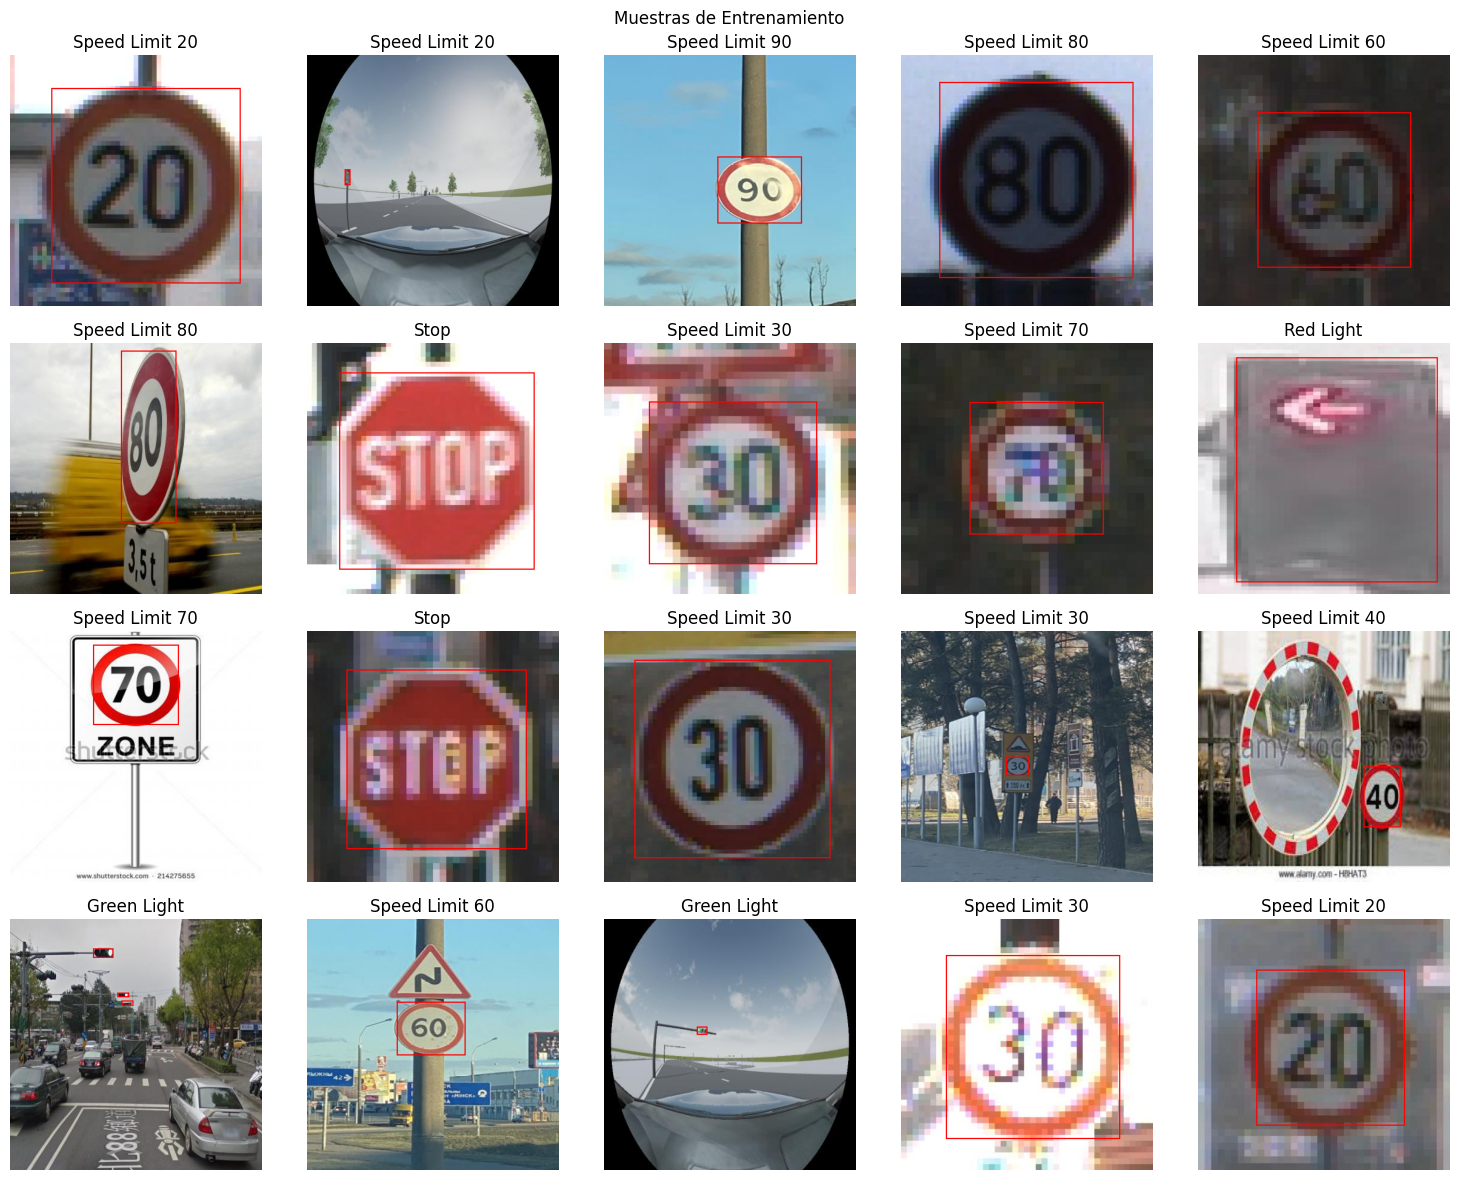

In [7]:
DATA_ROOT = Path('car')
if not DATA_ROOT.exists():
    raise FileNotFoundError(f"Ruta de datos no encontrada: {DATA_ROOT}")

root = DATA_ROOT
train_img = root / 'train' / 'images'
train_lbl = root / 'train' / 'labels'

# Definir clases
class_names = [
'Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110', 'Speed Limit 120',
'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70',
'Speed Limit 80', 'Speed Limit 90', 'Stop'
]

# 1. Conteo de imágenes y distribución numérica
counts = {}
for split in ['train', 'valid', 'test']:
    path = root / split / 'images'
    counts[split] = len(list(path.glob('*.*'))) if path.exists() else 0

# Mostrar tabla de distribución
dist = pd.Series(counts, name='count')
print(dist.to_frame())

# 2. Visualizar muestras con bounding boxes y título de clase
population = list(train_img.glob('*.*'))
if not population:
    raise FileNotFoundError(f"No se encontraron imágenes en {train_img}")

# Tomar hasta 20 muestras
k = min(20, len(population))
sample_images = random.sample(population, k)

n_cols = 5
n_rows = (k + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))

for ax, img_path in zip(axes.flatten(), sample_images):
    img = PImage.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    w, h = img.size

    lbl_path = train_lbl / f"{img_path.stem}.txt"
    title_labels = set()
    if lbl_path.exists():
        for line in lbl_path.read_text().splitlines():
            cls, x_c, y_c, bw, bh = map(float, line.split())
            # Convertir a coordenadas de pixeles
            cx, cy = x_c * w, y_c * h
            bw_pix, bh_pix = bw * w, bh * h
            x1, y1 = cx - bw_pix/2, cy - bh_pix/2
            x2, y2 = cx + bw_pix/2, cy + bh_pix/2
            draw.rectangle([x1, y1, x2, y2], outline='red', width=2)
            title_labels.add(class_names[int(cls)])

    ax.imshow(img)
    ax.set_title(", ".join(sorted(title_labels)) or "Sin etiqueta")
    ax.axis('off')

# Ocultar ejes sobrantes
for ax in axes.flatten()[k:]:
    ax.axis('off')

plt.suptitle('Muestras de Entrenamiento')
plt.tight_layout()
plt.show()



```
# This is formatted as code
```

### **2. Preparación y Modelamiento**

#### **Preparación**

Realizamos la configuración necesaria para que el modelo YOLO pueda utilizar el conjunto de datos. Esto incluye:

1. **Definición de las clases**: Se especifican las categorías de objetos que el modelo debe detectar. En este caso, las clases corresponden a diferentes tipos de señales de tránsito como 'Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', entre otros.

2. **Creación del archivo YAML**: Este archivo es esencial para entrenar modelos YOLO, ya que define la estructura del conjunto de datos. Contiene información como:
   - La ruta base del conjunto de datos.
   - Las particiones de entrenamiento, validación y prueba.
   - El número total de clases (`nc`).
   - Los nombres de las clases (`names`).

El archivo YAML asegura que el modelo pueda interpretar correctamente las imágenes y etiquetas durante el entrenamiento y la evaluación.

**En nuestro caso ya existe el archivo YAML, pero podemos crearlo de cero si es necesario**

In [8]:
# Crear animal-detection.yaml
yaml_content = f"""
path: {DATA_ROOT.absolute()}
train: train/images
val:   valid/images
test:  test/images

nc: {len(class_names)}
names: {class_names}
""".strip()
with open(DATA_ROOT / 'car-detection.yaml', 'w') as f:
    f.write(yaml_content)

#### **Modelamiento**

YOLO (“You Only Look Once”) cambió el paradigma de la detección de objetos al combinar en una sola red la localización y clasificación de instancias, evitando las etapas separadas de propuestas y refinamiento de métodos como R-CNN. Fue introducido por Redmon et al. en 2016 en *“You Only Look Once: Unified, Real-Time Object Detection”* ([ver paper](https://arxiv.org/abs/1506.02640)). Su flujo de datos se compone de:

1. **Backbone**  
   Una CNN profunda que extrae mapas de características a varios niveles de abstracción. En las familias modernas de YOLO suele emplearse CSPDarknet, que reduce la redundancia de gradiente y acelera el entrenamiento.

2. **Neck**  
   Una red de agregación multiescala (por ejemplo PANet o BiFPN) que fusiona los mapas del Backbone para capturar tanto objetos pequeños como grandes de forma eficiente.

3. **Head**  
   La capa final divide el mapa en una cuadrícula y, para cada celda, predice varias cajas delimitadoras, su confianza y la distribución de clases. Aplica Non-Max Suppression para filtrar solapamientos.

> A modo de ejemplo, la siguiente ilustración muestra el esquema general de YOLOv11, con sus tres bloques principales:
>  
> ![Arquitectura YOLOV11](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*L8rMuwurmyBH1ixIqcrMSQ.png)  

**Variantes de YOLOv11**

Para distintos balances de velocidad y precisión, YOLOv11 ofrece cinco tamaños preentrenados:

| Variante      | Parámetros aproximados | Uso recomendado                         |
|---------------|------------------------|-----------------------------------------|
| **v11n** (nano)   | ~2.6 M                   | Dispositivos edge, prototipado rápido    |
| **v11s** (small)  | ~9.4 M                   | Móviles, aplicaciones con recursos limitados |
| **v11m** (medium) | ~20.1 M                  | GPU de nivel medio, tareas generales     |
| **v11l** (large)  | ~25.3 M                  | Servidores potentes, máxima precisión     |
| **v11x** (XL)     | ~56.9 M                  | Investigación o despliegue en datacenter  |

En este laboratorio emplearemos **YOLOv11s**, que ofrece un buen compromiso entre velocidad de entrenamiento, latencia de inferencia y calidad de detección.


In [18]:
from ultralytics import YOLO

# Cargar modelo base (small)
model = YOLO('yolo11s.pt')

# Entrenar
results = model.train(
    data=str(root / 'car-detection.yaml'),
    epochs=20,
    imgsz=640,
    batch=16,
    patience=5,
    name='car_yolov11s'
)

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=car/car-detection.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=car_yolov11s3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=1

**Evaluemos el modelo**

YOLO guarda las curvas de entrenamiento y la matriz de confusión en runs/detect/car_yolov11s/.

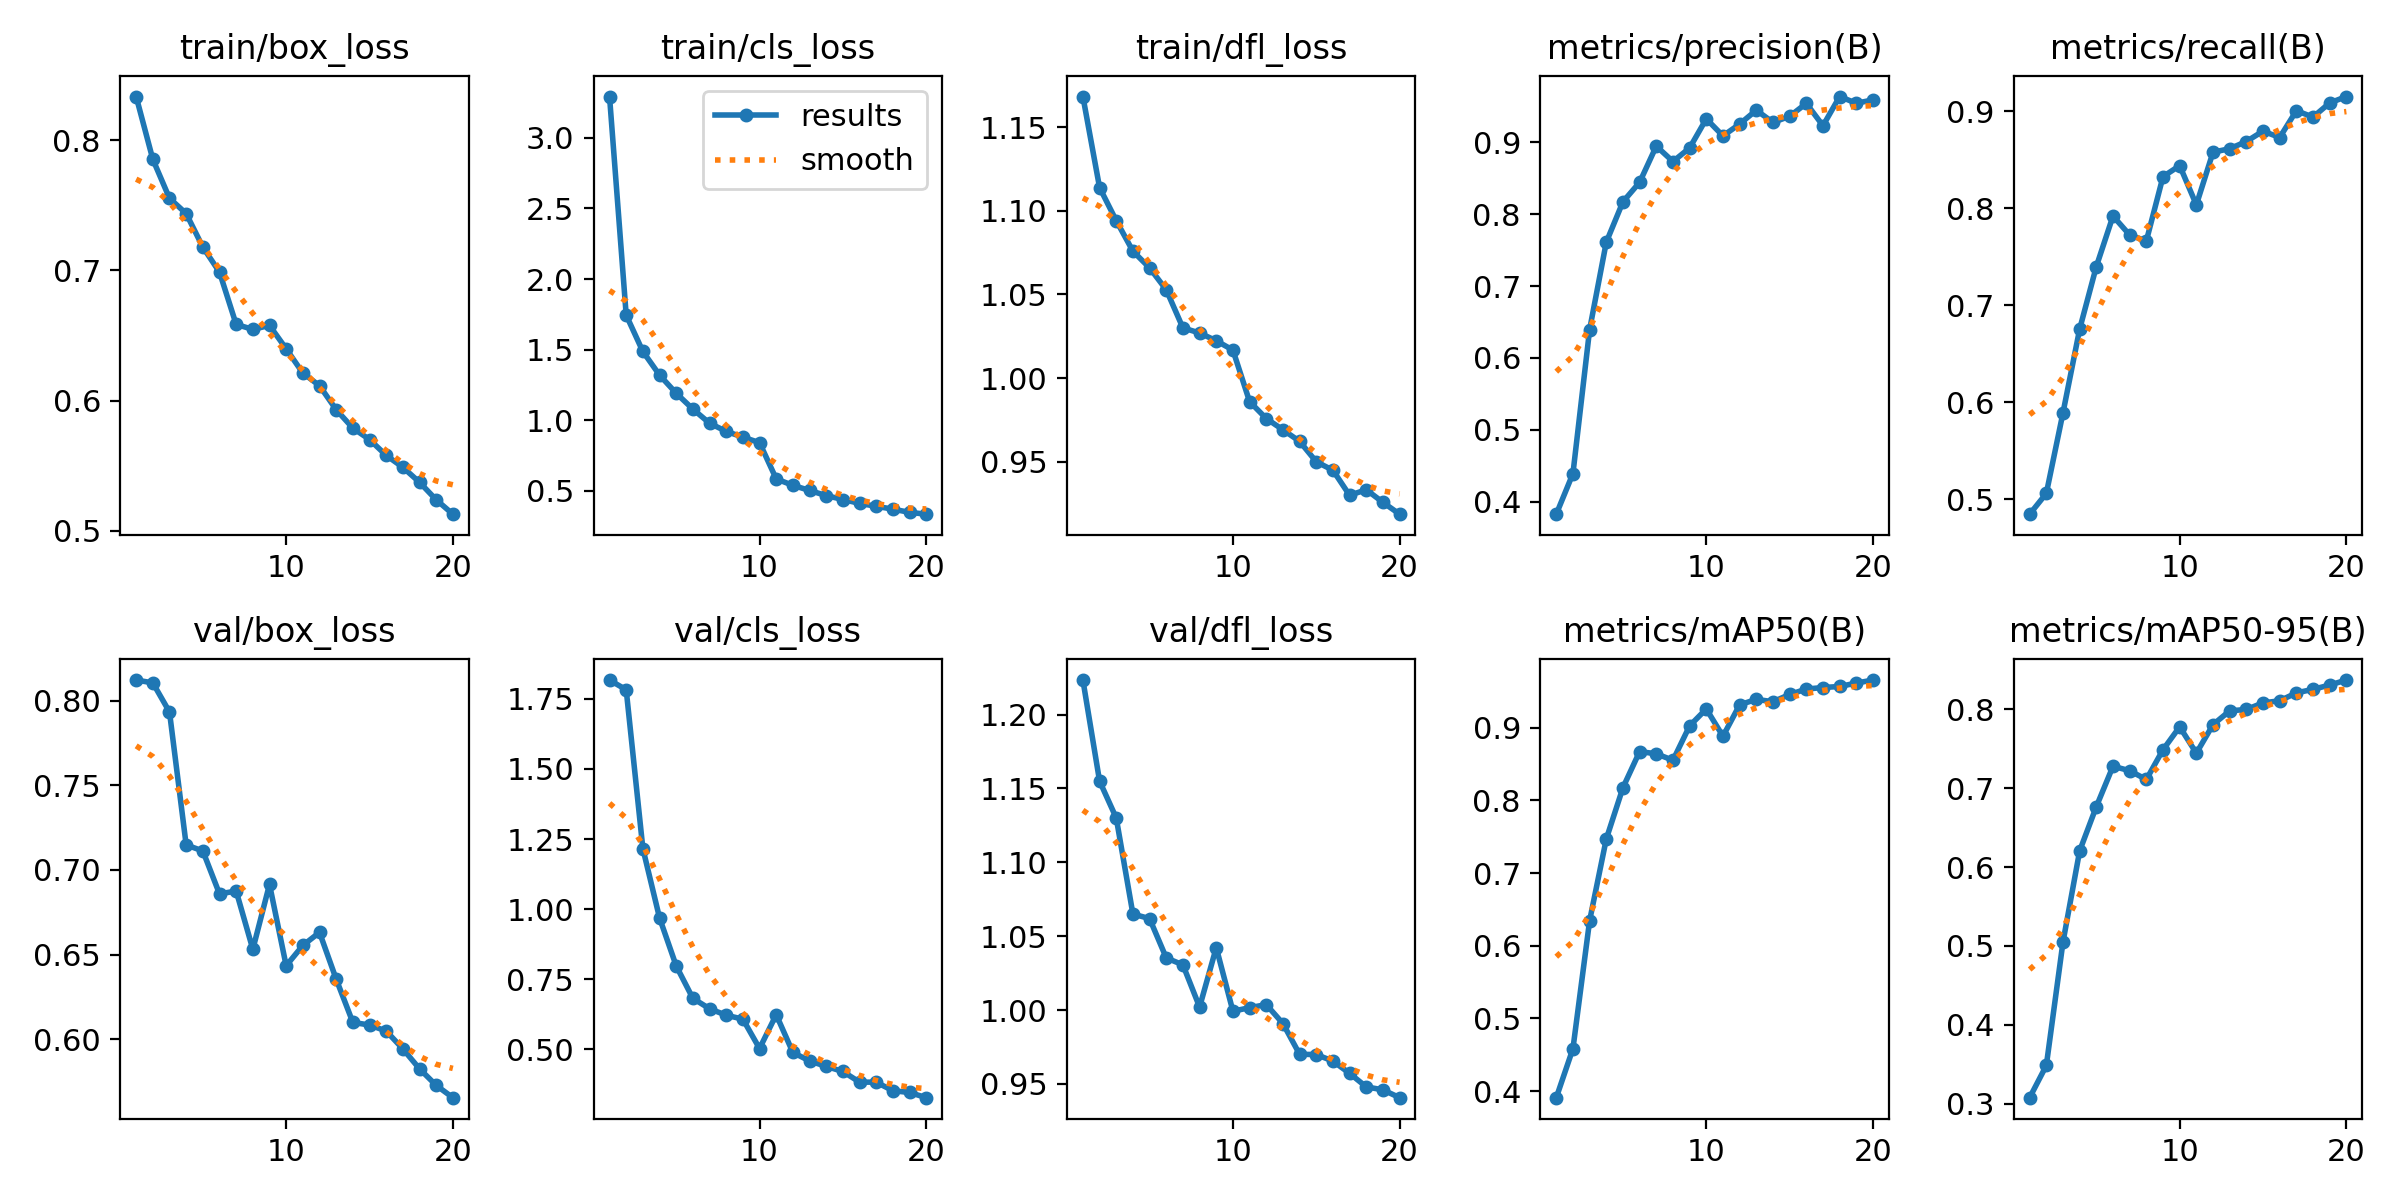

In [28]:
# Mostrar curva de mAP y loss
from PIL import Image as PImage
display(PImage.open('runs/detect/car_yolov11s3/results.png'))



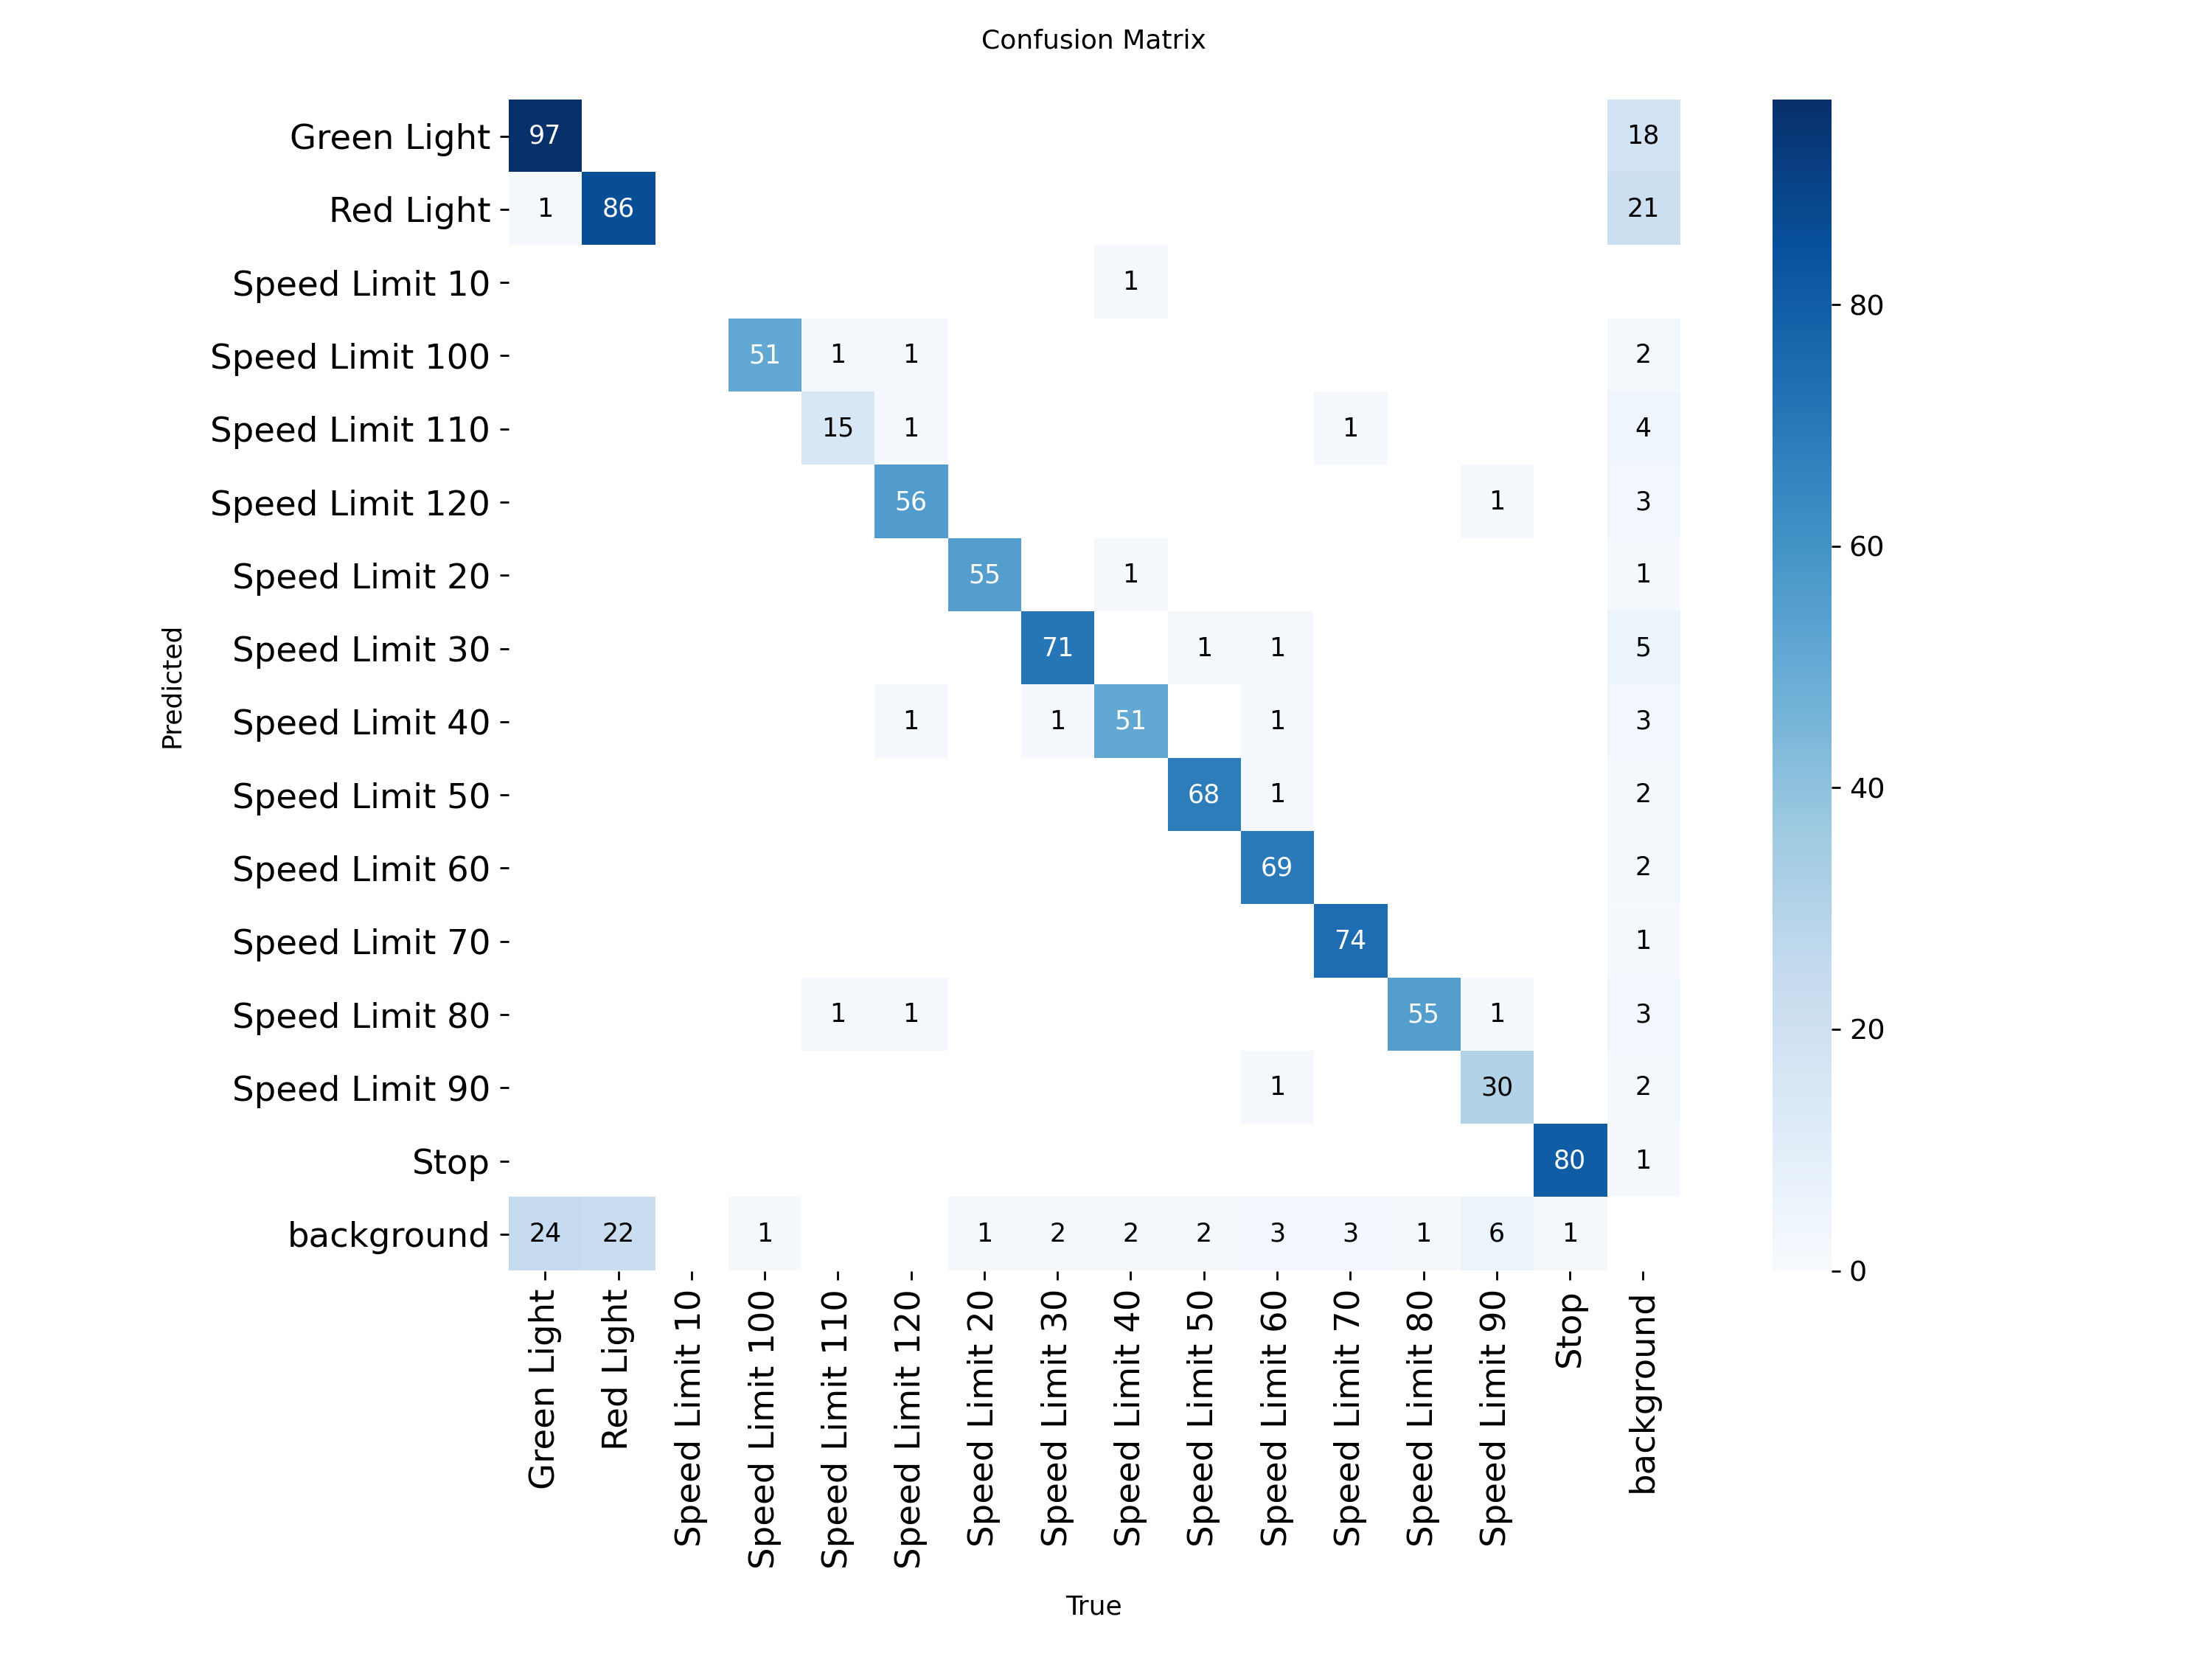

In [29]:
# Matriz de confusión
display(PImage.open('runs/detect/car_yolov11s3/confusion_matrix.png'))



```
# This is formatted as code
```

**Predicción e Inferencia**

Results saved to /content/runs/detect/car_yolov11s_predict


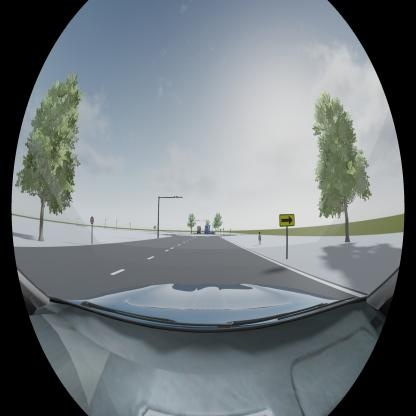

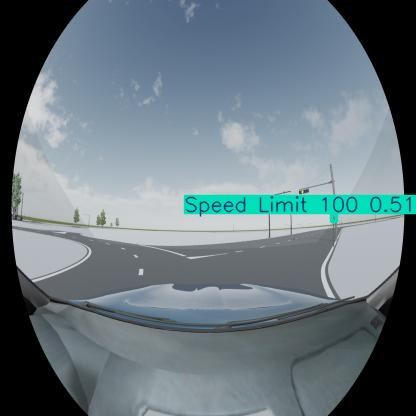

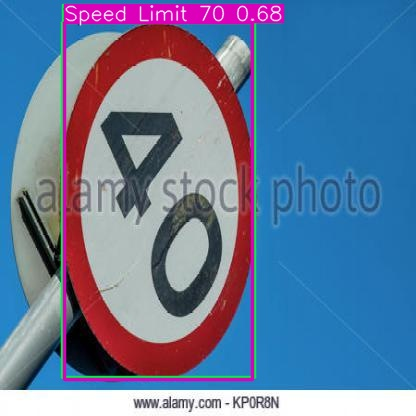

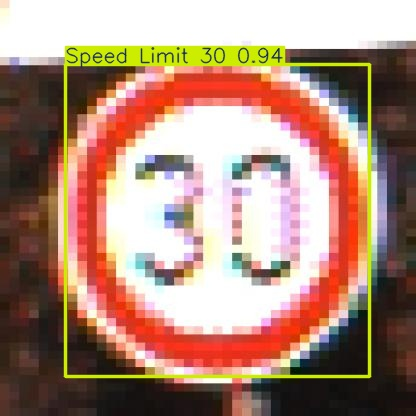

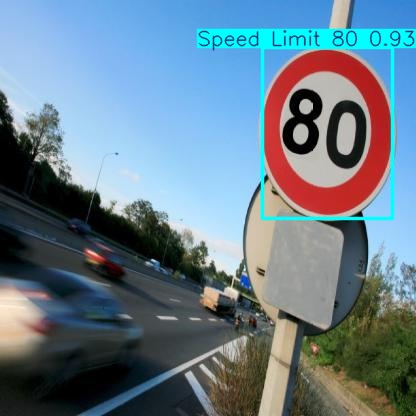

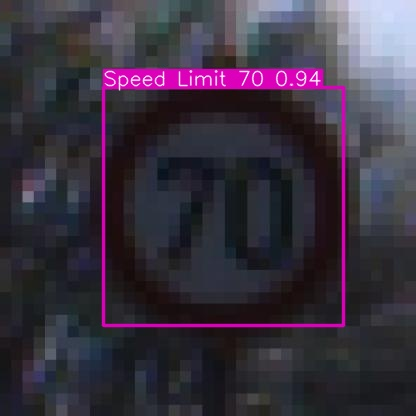

In [30]:
# Inferencia
preds = model.predict(
    source=str(root / 'test' / 'images'),
    conf=0.25,
    save=True,
    name='car_yolov11s_predict',
    verbose=False  # Suprimir mensajes en la consola
)

# Mostrar algunas predicciones
import glob
import random
from IPython.display import display

files = glob.glob('runs/detect/car_yolov11s_predict/*.jpg')
for img in random.sample(files, 6):
    display(PImage.open(img))

In [31]:

from pathlib import Path

DATA_ROOT = Path('car')
if not DATA_ROOT.exists():
    raise FileNotFoundError(f"Ruta de datos no encontrada: {DATA_ROOT}")

root = DATA_ROOT

### **3. Taller 2**

**Instrucciones**
1. El archivo a presentar debe ser en formato .ipynb o HTML con sus celdas ejecutadas. Celdas sin ejecutar no podrán ser evaluadas.
2. El nombre del archivo debe ser taller_2_{Apellido_Nombre}_{Apellido_Nombre} de cada integrante del equipo.
3. Las entregas solo se hacen a través de Bloque Neón.


1. **Velocidad vs. Precisión / Interpretabilidad de Resultados:**  
   - Comparar los tiempos de entrenamiento e inferencia entre las variantes `yolo11s` (small) y `yolo11n` (nano).
   - A partir de los resultados del modelo `yolo11s` y `yolo11n` qué diferencias encuentra en la evaluación de los modelos? Interprete las curvas de pérdida y los resultados del reporte de clasificación (no matriz de confusión).
   - ¿En qué escenarios es más conveniente usar cada variante (nano, small, medium, large, extra-large)? Cantidad de datos, recursos computacionales, etc.

2. **mAP50 vs. mAP50–95:**  
   - ¿Qué significa que mAP50 evalúe solo intersecciones sobre uniones (IoU) mayores o iguales a 0.5?  
   - ¿Qué información adicional proporciona evaluar el rango mAP50–95 al medir el rendimiento del modelo?

3. **Hiperparámetros críticos:**  
   - ¿Cómo afectan los valores de `batch` (tamaño de lote), `imgsz` (tamaño de imagen) y `patience` (paciencia para detener el entrenamiento) al tiempo de entrenamiento, uso de memoria y convergencia del modelo?

4. **Data Augmentation:**  
   - ¿Qué técnicas de aumento de datos podrían mejorar la capacidad del modelo para generalizar en diferentes escenarios?

## Punto 1



---


**Velocidad vs. Precisión / Interpretabilidad de Resultados:**


---

### Entrenamiento con YOLOv11n (nano)

Con el objetivo de comparar el desempeño entre diferentes variantes de la arquitectura YOLOv11, procedimos a entrenar el modelo **YOLOv11n**, utilizando el mismo conjunto de datos de detección de señales de tránsito.

Se mantuvieron constantes los hiperparámetros clave (número de épocas, tamaño de imagen, batch size, paciencia), para garantizar una comparación justa con la versión **YOLOv11s (small)** entrenada previamente.



---

In [35]:
from ultralytics import YOLO

# Cargar modelo base nano
model_nano = YOLO('yolo11n.pt')

# Entrenar
results_nano = model_nano.train(
    data=str(root / 'car-detection.yaml'),
    epochs=20,
    imgsz=640,
    batch=16,
    patience=5,
    name='car_yolov11n'
)

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=car/car-detection.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=car_yolov11n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12

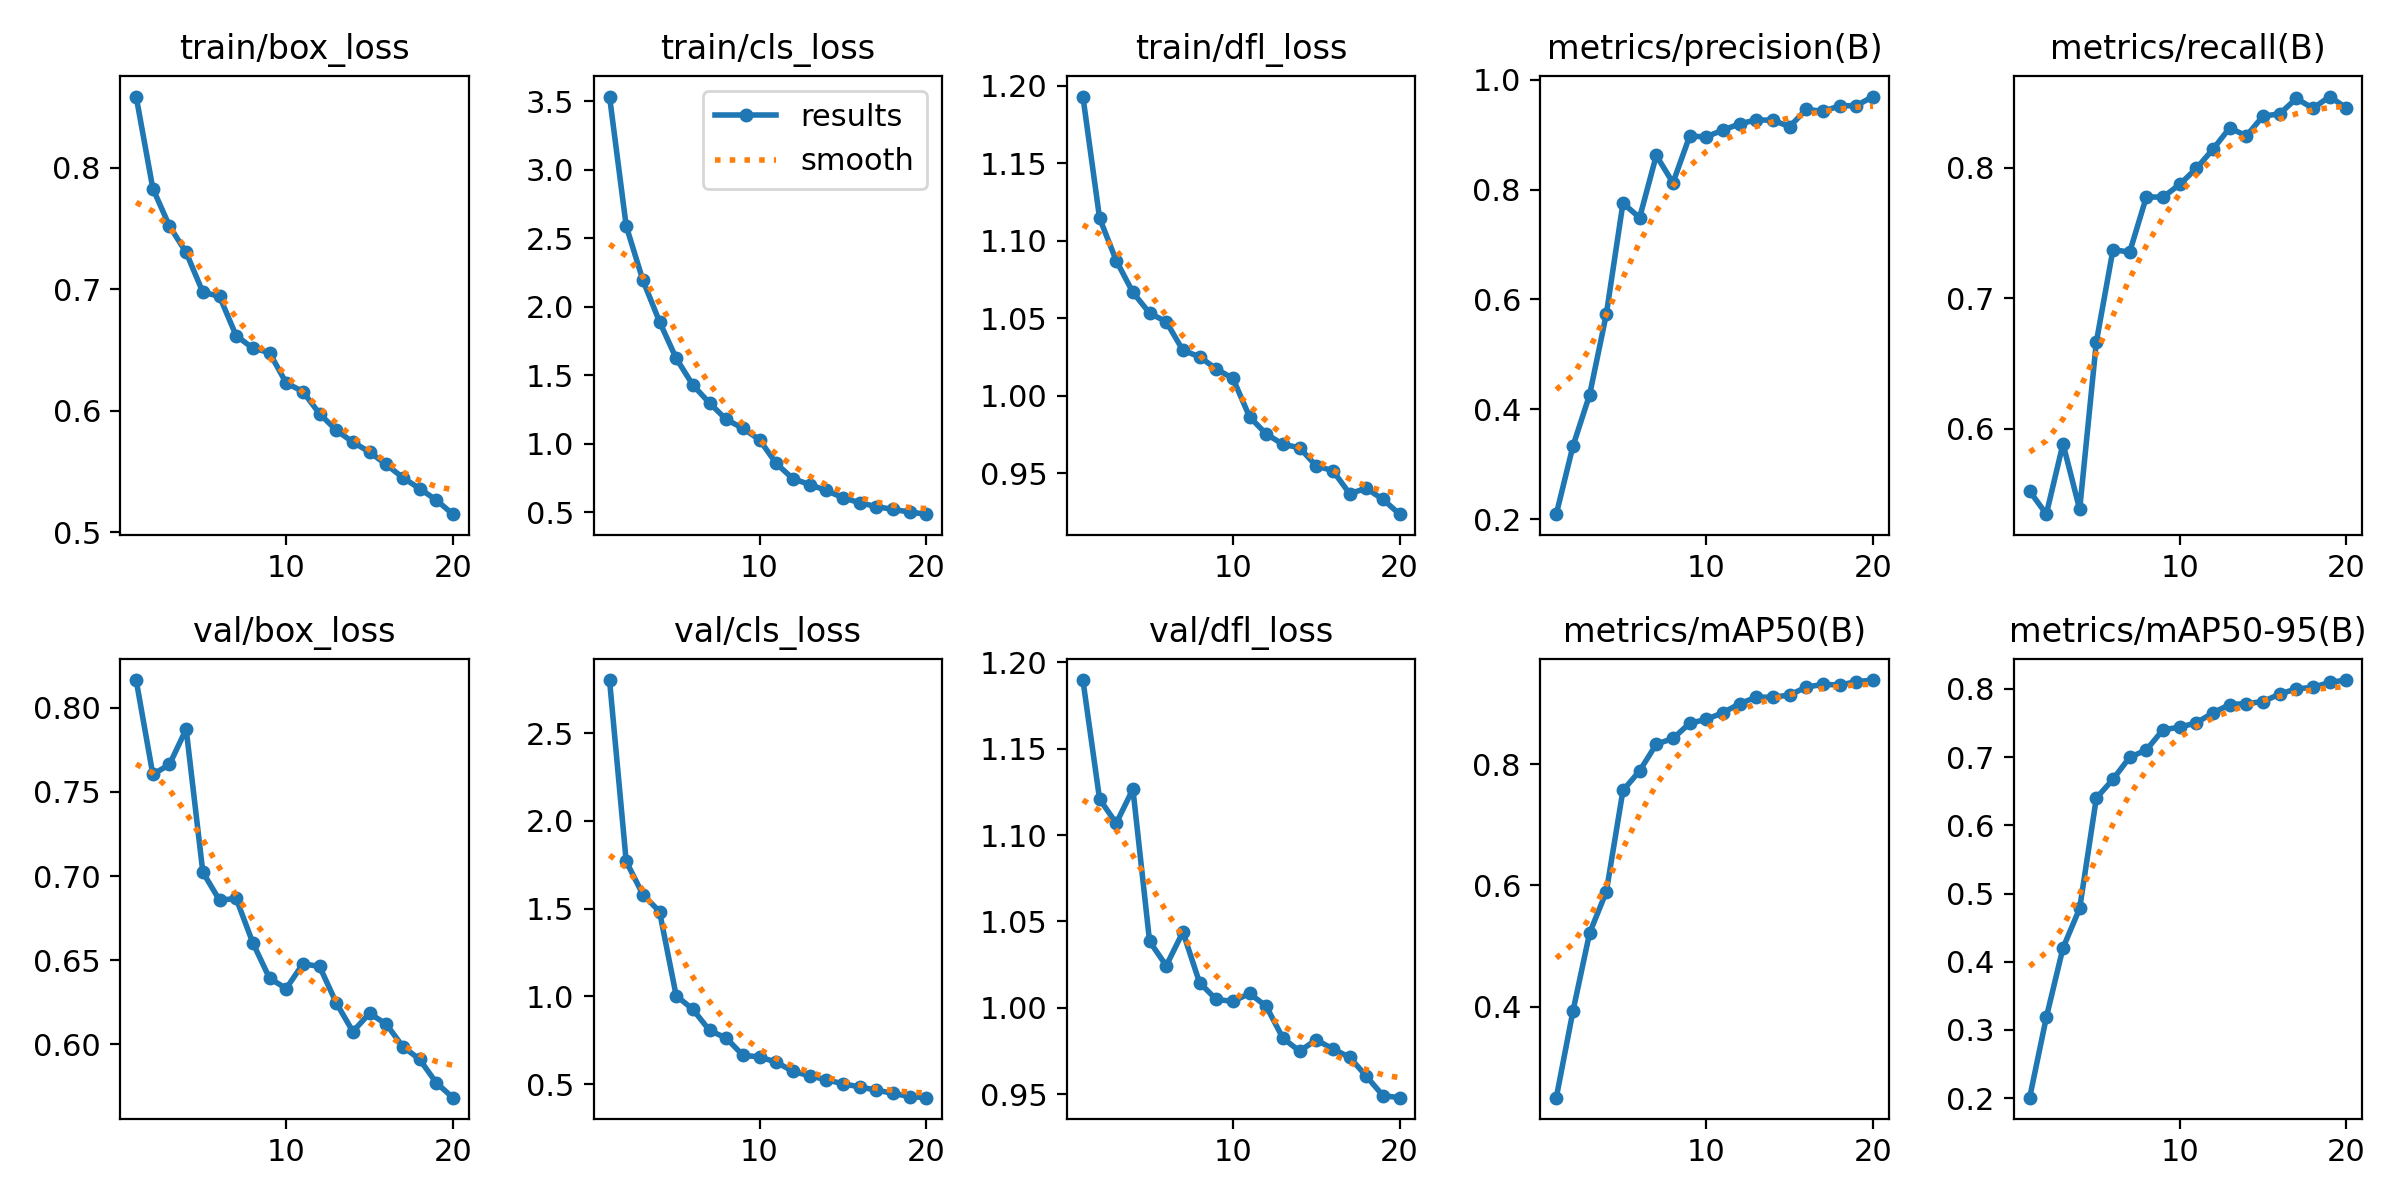

In [36]:
# Mostrar resultados de yolo11n
from PIL import Image as PImage
display(PImage.open('runs/detect/car_yolov11n/results.png'))


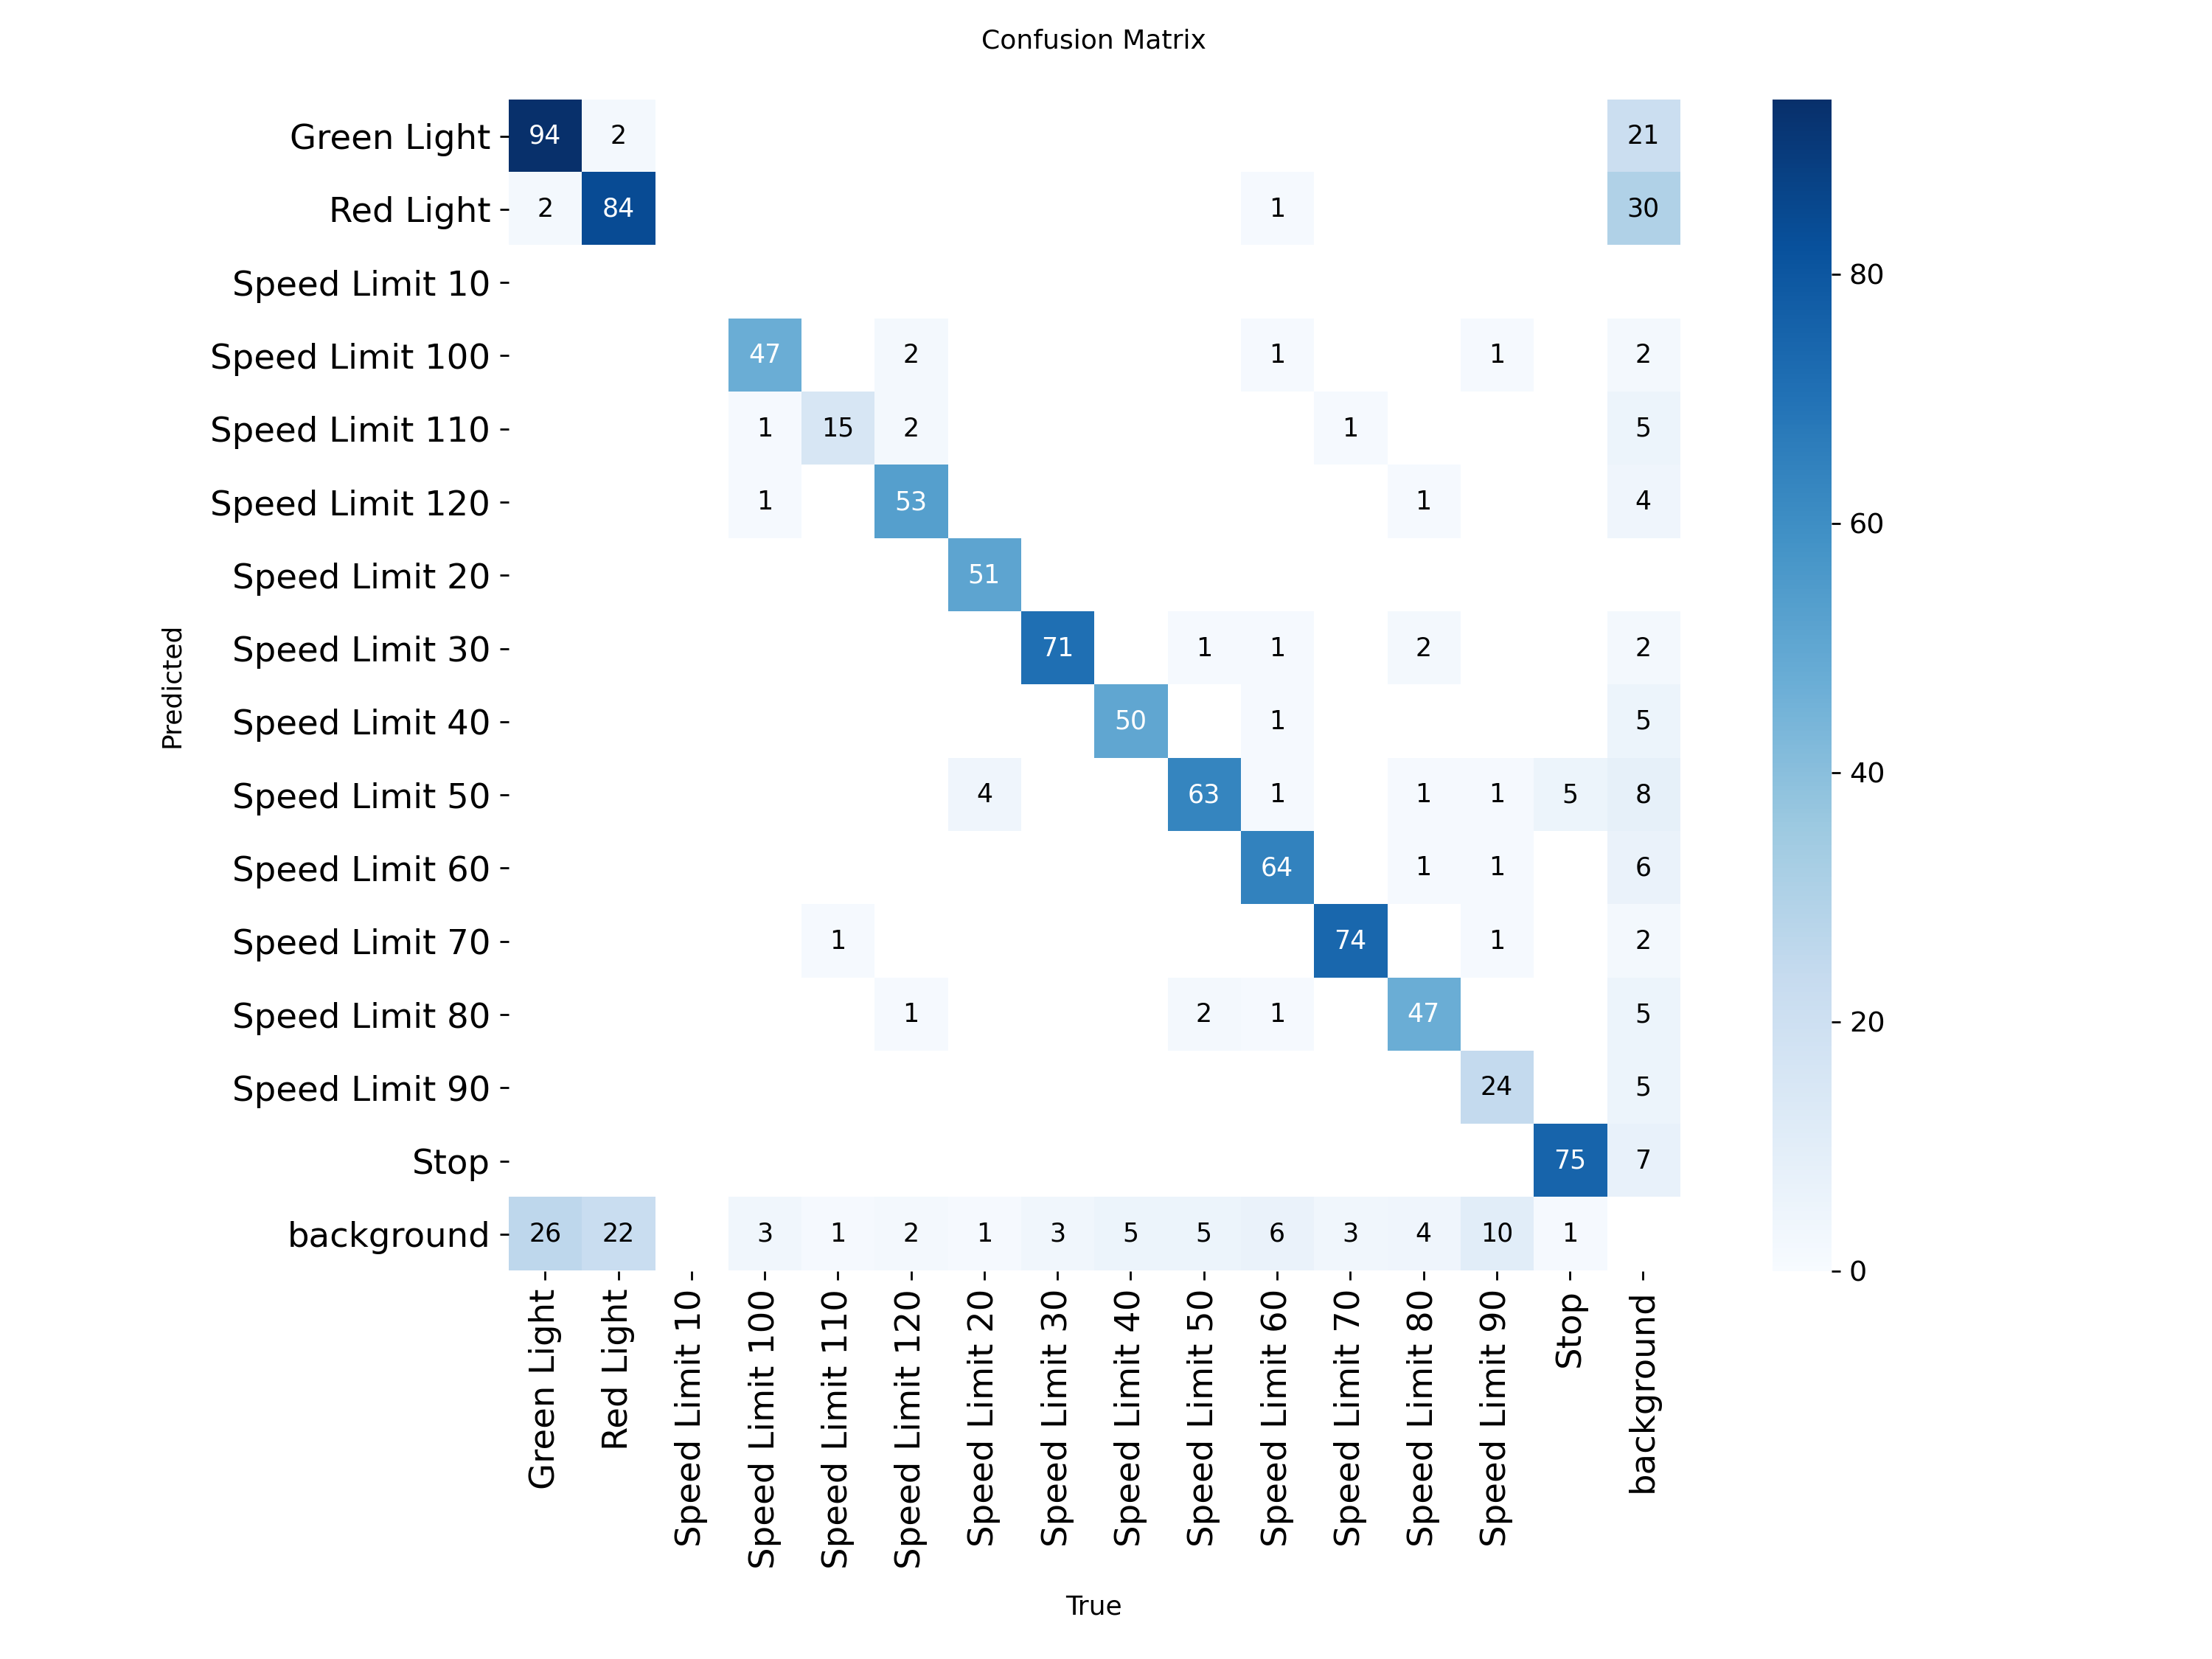

In [37]:
# Matriz de confusión
display(PImage.open('runs/detect/car_yolov11n/confusion_matrix.png'))

## Punto 2

---

### **mAP50 vs. mAP50–95**

---

#### ¿Qué significa que mAP50 evalúe solo intersecciones sobre uniones (IoU) mayores o iguales a 0.5?

La métrica mAP50 (mean Average Precision con umbral IoU ≥ 0.5) mide qué tan bien el modelo detecta objetos cuando al menos el 50% del área predicha se superpone con el área real (ground truth). Es una métrica tolerante que considera como correcta una predicción si la intersección entre la predicción y el objeto real es razonablemente buena (≥50%).

En términos prácticos, mAP50 evalúa si el modelo acierta de forma general a la ubicación de los objetos, sin exigir demasiada precisión en los bordes.

---

####  ¿Qué información adicional proporciona evaluar el rango mAP50–95 al medir el rendimiento del modelo?

La métrica mAP50–9 promedia el desempeño del modelo en 10 diferentes umbrales de IoU, desde 0.5 hasta 0.95 en incrementos de 0.05. Esto implica evaluar qué tan bien el modelo puede localizar los objetos de manera más precisa, y no solo aproximarse.

Mientras que mAP50 premia la detección general, mAP50–95 es más exigente y refleja la capacidad del modelo para predecir con precisión la forma y posición exacta de los objetos.

---

#### Haciendo un comparativo

| Métrica      | Evalúa...                          | Exigencia | Uso principal                              |
|--------------|------------------------------------|-----------|--------------------------------------------|
| **mAP50**     | IoU ≥ 0.5 (detección general)       | Baja      | Comparar modelos rápidamente, prototipado  |
| **mAP50–95**  | IoU desde 0.5 hasta 0.95            | Alta      | Evaluar precisión fina en localización     |

---







### Comparar los tiempos de entrenamiento e inferencia entre las variantes yolo11s (small) y yolo11n (nano).

- El modelo YOLOv11n (nano) completó el entrenamiento en aproximadamente 0.38 horas, usando ~3.0 GB de memoria GPU.  
- El modelo YOLOv11s (small) tardó ligeramente más: 0.43 horas, con un uso pico de ~5.6 GB de GPU.

- El tiempo de inferencia por imagen también reflejó la diferencia en complejidad:
  - YOLOv11n: ~2.6 ms por imagen
  - YOLOv11s: ~4.7 ms por imagen

Esto confirma que YOLOv11n es más rápido y liviano, ideal para despliegue en dispositivos de bajo recurso, mientras que YOLOv11s es más pesado pero ofrece mayor precisión.

---

### A partir de los resultados del modelo yolo11s y yolo11n ¿qué diferencias se encuentran en la evaluación? Interpretación de curvas de pérdida y reporte de clasificación (no matriz de confusión).

- YOLOv11 logró métricas superiores:
  - `mAP50 = 0.966`, `mAP50–95 = 0.837`
  - Precisión y recall final: `P = 0.959`, `R = 0.915`

- YOLOv11* también tuvo un buen desempeño, aunque ligeramente menor:
  - `mAP50 = 0.939`, `mAP50–95 = 0.813`
  - Precisión y recall final: `P = 0.971`, `R = 0.846`

- Las curvas de pérdida (box, cls, dfl) disminuyeron de forma más estable en YOLOv11s, indicando mejor convergencia y menor oscilación durante el entrenamiento.

- El reporte de clasificación final muestra que YOLOv11s generaliza mejor para clases minoritarias y complejas como "Speed Limit 90", "Red Light", mientras que YOLOv11n tiende a tener más variación en sus IoUs.


---

### ¿En qué escenarios es más conveniente usar cada variante (nano, small, medium, large, extra-large)? Cantidad de datos, recursos computacionales, etc.

| Variante      | Uso Recomendado                                           |
|---------------|------------------------------------------------------------|
| **Nano**      | Dispositivos con pocos recursos (IoT, drones, móviles), inferencia en tiempo real donde la precisión no es crítica. |
| **Small**     | Buen equilibrio entre rendimiento y velocidad, ideal para aplicaciones móviles o web con recursos moderados. |
| **Medium**    | Cuando se cuenta con más datos y capacidad de cómputo; mejor precisión sin requerimientos tan altos como Large. |
| **Large**     | Proyectos industriales o de investigación con datasets amplios y buena infraestructura (GPUs). |
| **Extra-Large** | Escenarios donde la **precisión extrema es clave**, y se dispone de **entrenamiento distribuido** o **servidores especializados**. Muy útil en medicina, vigilancia avanzada, etc. |

---

## Punto 3

---

### **Hiperparámetros críticos**

---

¿Cómo afectan los valores de batch (tamaño de lote), imgsz (tamaño de imagen) y patience (paciencia para detener el entrenamiento) al tiempo de entrenamiento, uso de memoria y convergencia del modelo?

---

#### **batch (tamaño de lote)**

- Define cuántas imágenes se procesan simultáneamente en cada paso de entrenamiento.
- Afecta directamente el uso de memoria GPU es decir lotes más grandes consumen más memoria.
- Lotes pequeños (8–16):
  - Mejor generalización.
  - Entrenamiento más lento.
- Lotes grandes (32–64+):
  - Entrenamiento más rápido por epoch.
  - Mayor riesgo de sobreajuste y necesidad de más memoria.

En este laboratorio se usó `batch=16`, un valor balanceado para tarjetas como la Tesla T4.

---

#### **imgsz (tamaño de imagen)**

- Controla el tamaño al que se redimensionan todas las imágenes de entrada.
- Tamaños mayores capturan más detalles, pero aumentan el costo computacional.
- Tamaños pequeños (320–416):
  - Entrenamiento e inferencia más rápidos.
  - Menor precisión, especialmente en objetos pequeños.
- Tamaños grandes (640+):
  - Mejor detección de objetos pequeños.
  - Mayor uso de memoria y tiempo por epoch.

Aquí se empleó `imgsz=640`, un valor recomendado por defecto para YOLOv11.

---

#### **patience (paciencia de EarlyStopping)**

- Controla cuántas epochs sin mejora se toleran antes de detener el entrenamiento.
- No afecta memoria ni velocidad por epoch**, pero sí la duración total del entrenamiento.
- Valores bajos:
  - Evitan sobreentrenamiento.
  - Riesgo de detener el entrenamiento prematuramente.
- Valores altos:
  - Permiten alcanzar una mejor convergencia.
  - Mayor tiempo total de entrenamiento.

Se utilizó `patience=5`, permitiendo cierto margen para mejorar sin alargar demasiado el entrenamiento.

---

Haciendo un comparativo

| Hiperparámetro | Afecta | Consideraciones |
|----------------|--------|-----------------|
| `batch`        | Memoria y velocidad por epoch | Mayor batch = +velocidad, +uso de GPU |
| `imgsz`        | Precisión y tiempo por imagen | Mayor imgsz = +detalle, +coste |
| `patience`     | Duración total del entrenamiento | Mayor patience = +convergencia, +tiempo |

---

---

## Punto 4

---

¿Qué técnicas de aumento de datos podrían mejorar la capacidad del modelo para generalizar en diferentes escenarios?

---
El Data Augmentation es una técnica que busca generar variaciones artificiales del conjunto de entrenamiento para mejorar la capacidad del modelo de generalizar ante nuevos escenarios.

En el caso de detección de objetos con YOLO, se aplican transformaciones tanto sobre la imagen como sobre las cajas delimitadoras (`bounding boxes`). Algunas técnicas recomendadas son:

---

#### **Transformaciones geométricas**

- Flip horizontal: invierte la imagen de forma lateral. Útil en escenarios donde la orientación no cambia el significado.
- Rotación aleatoria: simula inclinaciones leves.
- Escalado y recortes: cambia el tamaño y encuadre del objeto.
- Traslación: desplaza el objeto en la imagen.

---

#### **Cambios en iluminación y color**

- Ajuste de brillo, contraste y saturación**: simula distintas condiciones de luz.
- Transformaciones HSV (Hue, Saturation, Value): cambian tonalidad de colores sin alterar la estructura.
- Sombras o ruido aleatorio: mejora robustez ante imágenes degradadas o con interferencias.

---

####  **Técnicas avanzadas**

- Mosaic augmentation: combina 4 imágenes en una sola, permitiendo múltiples objetos y escalas en una sola imagen. Muy efectiva en YOLOv4 en adelante.
- MixUp / CutMix: mezcla dos imágenes y sus anotaciones para suavizar decisiones del modelo.
- Random Erasing / Occlusion: borra partes de la imagen para forzar al modelo a enfocarse en otras regiones.

---

 Nota: El entrenamiento con Ultralytics YOLOv8 y YOLOv11 ya incluye por defecto algunas de estas técnicas, como:
 - `flip`, `scale`, `hsv` y `mosaic`.
 - Se configuran automáticamente o se pueden ajustar manualmente en el archivo de configuración del modelo o como parámetros de entrenamiento.

---

**Conclusión**:

Aplicar augmentations apropiadas reduce el overfitting, mejora la robustez del modelo ante condiciones del mundo real y permite mejor generalización aún con conjuntos de datos limitados.

---

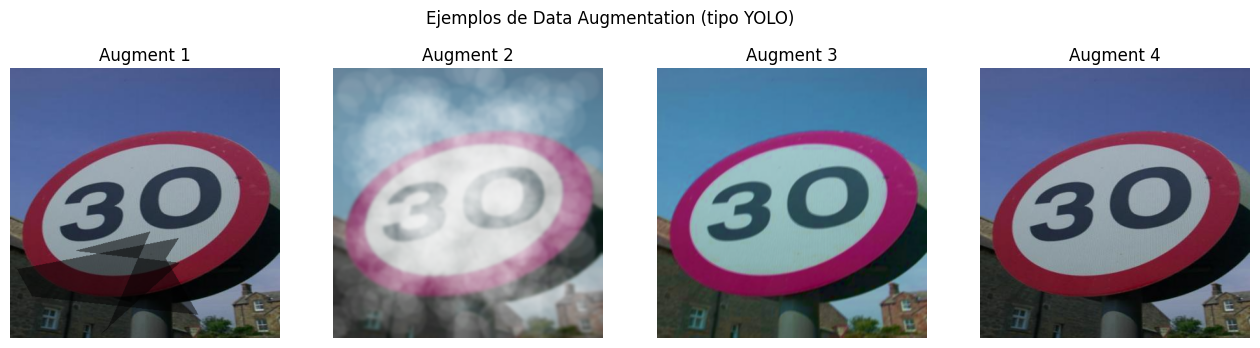

In [9]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt

# Definir augmentations similares a los usados por YOLO
transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RandomShadow(p=0.3),
    A.RandomFog(p=0.2),
    A.MotionBlur(p=0.2),
])

# Tomar una imagen del set
img_path = str((root / 'train' / 'images').glob('*.jpg').__next__())
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Aplicar augmentations múltiples veces
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    aug_img = transform(image=image)["image"]
    axs[i].imshow(aug_img)
    axs[i].axis("off")
    axs[i].set_title(f"Augment {i+1}")
plt.suptitle("Ejemplos de Data Augmentation (tipo YOLO)")
plt.show()